In [1]:
# Notebook setup (segment pipeline) / Notebook 初始化（segment 管线）
import os
from pathlib import Path
import sqlite3
import sys
import pandas as pd

def _find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

try:
    from airline_revenue_analytics.config import get_paths
except ModuleNotFoundError:
    # Fall back to src/ on sys.path for notebook runs.
    repo_root = _find_repo_root(Path.cwd())
    src_root = repo_root / "src"
    if str(src_root) not in sys.path:
        sys.path.append(str(src_root))
    try:
        from airline_revenue_analytics.config import get_paths
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("Install the package first: pip install -e .") from exc

# Resolve repo paths and DB location / 解析仓库路径与数据库位置
paths = get_paths("segment")
REPO_ROOT = paths.repo_root
DATA_DIR = paths.data_raw
OUT_DIR = paths.outputs_root
FIG_DIR = paths.figures
TAB_DIR = paths.tables
DB_PATH = paths.db_path
db_path = DB_PATH

# SQLite connection (shared across cells) / SQLite 连接（全局复用）
conn = sqlite3.connect(DB_PATH)

def _rel(p: Path) -> str:
    """Render repo-relative paths for display / 将路径显示为仓库相对路径."""
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return str(p)

def find_path(filename: str) -> Path:
    """Locate a file under outputs/ or data/raw / 在 outputs/ 或 data/raw 中定位文件."""
    for p in (OUT_DIR / filename, DATA_DIR / filename, REPO_ROOT / filename):
        if p.exists():
            return p
    for root, _, files in os.walk(OUT_DIR):
        if filename in files:
            return Path(root) / filename
    raise FileNotFoundError(
        f"Cannot find {filename}. Put it under data/raw or outputs/segment."
    )


In [2]:
import importlib.util
from airline_revenue_analytics.config import get_paths

print(importlib.util.find_spec("airline_revenue_analytics"))

paths = get_paths("segment")
print("DB_PATH:", paths.db_path)
print("DB exists:", paths.db_path.exists())

ModuleSpec(name='airline_revenue_analytics', loader=<_frozen_importlib_external.SourceFileLoader object at 0x129cc3590>, origin='/Users/ethan/Documents/GitHub/airline-revenue-analytics/src/airline_revenue_analytics/__init__.py', submodule_search_locations=['/Users/ethan/Documents/GitHub/airline-revenue-analytics/src/airline_revenue_analytics'])
DB_PATH: /Users/ethan/Documents/GitHub/airline-revenue-analytics/data/raw/airlines_db.sqlite
DB exists: True


In [3]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [4]:
# Environment and Path Check / 环境与路径检查
import os, sqlite3
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

print("CWD:", os.getcwd())
print("DATA_DIR:", _rel(DATA_DIR))
print("Contents of data dir:", [p.name for p in DATA_DIR.iterdir()] if DATA_DIR.exists() else "MISSING")

if not DB_PATH.exists():
    raise FileNotFoundError("SQLite not found at DB_PATH. Set AIRLINE_DB_PATH or place the DB under data/raw.")
db_path = str(DB_PATH)
print("Using database:", _rel(DB_PATH))


CWD: /Users/ethan/Documents/GitHub/airline-revenue-analytics/notebooks/segment
DATA_DIR: data/raw
Contents of data dir: ['README.md', 'airlines_db.sqlite']
Using database: data/raw/airlines_db.sqlite


In [5]:
# Use shared database connection / 使用共享数据库连接

# List all tables / 列出所有表
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)['name'].tolist()
print(f"Found {len(tables)} tables in total:", tables)

# Row count audit / 行数审计
counts = []
for t in tables:
    n = pd.read_sql(f"SELECT COUNT(*) AS n FROM [{t}];", conn)['n'].iat[0]
    counts.append((t, n))
counts_df = (
    pd.DataFrame(counts, columns=['table', 'rows'])
      .sort_values('rows', ascending=False)
      .reset_index(drop=True)
)
counts_df  # Display as a neat table, screenshot this part

Found 8 tables in total: ['aircrafts_data', 'airports_data', 'boarding_passes', 'bookings', 'flights', 'seats', 'ticket_flights', 'tickets']


,table,rows
0,ticket_flights,1045726
1,boarding_passes,579686
2,tickets,366733
3,bookings,262788
4,flights,33121
5,seats,1339
6,airports_data,104
7,aircrafts_data,9


In [6]:
for t in tables:
    print(f"\n===== {t} (first 5 rows) =====")
    display(pd.read_sql(f"SELECT * FROM [{t}] LIMIT 5;", conn))

# conn.close() / 关闭连接



===== aircrafts_data (first 5 rows) =====


,aircraft_code,model,range
0,773,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100
1,763,"{""en"": ""Boeing 767-300"", ""ru"": ""Боинг 767-300""}",7900
2,SU9,"{""en"": ""Sukhoi Superjet-100"", ""ru"": ""Сухой Суп...",3000
3,320,"{""en"": ""Airbus A320-200"", ""ru"": ""Аэробус A320-...",5700
4,321,"{""en"": ""Airbus A321-200"", ""ru"": ""Аэробус A321-...",5600



===== airports_data (first 5 rows) =====


,airport_code,airport_name,city,coordinates,timezone
0,YKS,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}","{""en"": ""Yakutsk"", ""ru"": ""Якутск""}","(129.77099609375,62.0932998657226562)",Asia/Yakutsk
1,MJZ,"{""en"": ""Mirny Airport"", ""ru"": ""Мирный""}","{""en"": ""Mirnyj"", ""ru"": ""Мирный""}","(114.03900146484375,62.534698486328125)",Asia/Yakutsk
2,KHV,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...","{""en"": ""Khabarovsk"", ""ru"": ""Хабаровск""}","(135.18800354004,48.5279998779300001)",Asia/Vladivostok
3,PKC,"{""en"": ""Yelizovo Airport"", ""ru"": ""Елизово""}","{""en"": ""Petropavlovsk"", ""ru"": ""Петропавловск-К...","(158.453994750976562,53.1679000854492188)",Asia/Kamchatka
4,UUS,"{""en"": ""Yuzhno-Sakhalinsk Airport"", ""ru"": ""Хом...","{""en"": ""Yuzhno-Sakhalinsk"", ""ru"": ""Южно-Сахали...","(142.718002319335938,46.8886985778808594)",Asia/Sakhalin



===== boarding_passes (first 5 rows) =====


,ticket_no,flight_id,boarding_no,seat_no
0,0005435212351,30625,1,2D
1,0005435212386,30625,2,3G
2,0005435212381,30625,3,4H
3,0005432211370,30625,4,5D
4,0005435212357,30625,5,11A



===== bookings (first 5 rows) =====


,book_ref,book_date,total_amount
0,00000F,2017-07-05 03:12:00+03,265700
1,000012,2017-07-14 09:02:00+03,37900
2,000068,2017-08-15 14:27:00+03,18100
3,000181,2017-08-10 13:28:00+03,131800
4,0002D8,2017-08-07 21:40:00+03,23600



===== flights (first 5 rows) =====


,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,PG0134,2017-09-10 09:50:00+03,2017-09-10 14:55:00+03,DME,BTK,Scheduled,319,\N,\N
1,3979,PG0052,2017-08-25 14:50:00+03,2017-08-25 17:35:00+03,VKO,HMA,Scheduled,CR2,\N,\N
2,4739,PG0561,2017-09-05 12:30:00+03,2017-09-05 14:15:00+03,VKO,AER,Scheduled,763,\N,\N
3,5502,PG0529,2017-09-12 09:50:00+03,2017-09-12 11:20:00+03,SVO,UFA,Scheduled,763,\N,\N
4,6938,PG0461,2017-09-04 12:25:00+03,2017-09-04 13:20:00+03,SVO,ULV,Scheduled,SU9,\N,\N



===== seats (first 5 rows) =====


,aircraft_code,seat_no,fare_conditions
0,319,2A,Business
1,319,2C,Business
2,319,2D,Business
3,319,2F,Business
4,319,3A,Business



===== ticket_flights (first 5 rows) =====


,ticket_no,flight_id,fare_conditions,amount
0,0005432159776,30625,Business,42100
1,0005435212351,30625,Business,42100
2,0005435212386,30625,Business,42100
3,0005435212381,30625,Business,42100
4,0005432211370,30625,Business,42100



===== tickets (first 5 rows) =====


,ticket_no,book_ref,passenger_id
0,0005432000987,06B046,8149 604011
1,0005432000988,06B046,8499 420203
2,0005432000989,E170C3,1011 752484
3,0005432000990,E170C3,4849 400049
4,0005432000991,F313DD,6615 976589


In [7]:
import pandas as pd, sqlite3, glob, os, io
from IPython.display import display

# Try to read the 8 common tables of an airline database (only those that actually exist will be loaded) / 尝试读取航空数据库常见 8 表（仅加载实际存在者）
core = ['bookings','tickets','ticket_flights','flights',
        'boarding_passes','seats','aircrafts_data','airports_data']
exists = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'].tolist()
TABLES = [t for t in core if t in exists]

dfs = {t: pd.read_sql(f"SELECT * FROM [{t}];", conn) for t in TABLES}

overview = (pd.DataFrame([(t, df.shape[0], df.shape[1]) for t, df in dfs.items()],
                         columns=['table','rows','cols'])
              .sort_values('rows', ascending=False).reset_index(drop=True))
display(overview)  # A screenshot of this can serve as evidence of the data's scale (fulfills requirement 2.2)

,table,rows,cols
0,ticket_flights,1045726,4
1,boarding_passes,579686,4
2,tickets,366733,3
3,bookings,262788,3
4,flights,33121,10
5,seats,1339,3
6,airports_data,104,5
7,aircrafts_data,9,3


In [8]:
import io
for t, df in dfs.items():
    print(f"\n===== {t}: df.info() =====")
    buf = io.StringIO()
    df.info(buf=buf)
    print(buf.getvalue())    # Screenshot a few core tables (e.g., bookings / flights / ticket_flights / tickets)


===== bookings: df.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262788 entries, 0 to 262787
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   book_ref      262788 non-null  object
 1   book_date     262788 non-null  object
 2   total_amount  262788 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


===== tickets: df.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366733 entries, 0 to 366732
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ticket_no     366733 non-null  object
 1   book_ref      366733 non-null  object
 2   passenger_id  366733 non-null  object
dtypes: object(3)
memory usage: 8.4+ MB


===== ticket_flights: df.info() =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045726 entries, 0 to 1045725
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dt

In [9]:
for t, df in dfs.items():
    print(f"\n===== {t}: df.describe() (numeric) =====")
    try:
        display(df.describe(datetime_is_numeric=True).T)
    except TypeError:
        display(df.describe().T)


===== bookings: df.describe() (numeric) =====


,count,mean,std,min,25%,50%,75%,max
total_amount,262788.0,79025.605812,77621.922723,3400.0,29000.0,55900.0,99200.0,1204500.0



===== tickets: df.describe() (numeric) =====


,count,unique,top,freq
ticket_no,366733,366733,0005432000987,1
book_ref,366733,262788,6252BD,5
passenger_id,366733,366733,8149 604011,1



===== ticket_flights: df.describe() (numeric) =====


,count,mean,std,min,25%,50%,75%,max
flight_id,1045726.0,14110.057798,9732.943994,1.0,5501.0,11926.0,23039.0,33121.0
amount,1045726.0,19858.912277,22612.387509,3000.0,7200.0,13400.0,23100.0,203300.0



===== flights: df.describe() (numeric) =====


,count,mean,std,min,25%,50%,75%,max
flight_id,33121.0,16561.0,9561.353469,1.0,8281.0,16561.0,24841.0,33121.0



===== boarding_passes: df.describe() (numeric) =====


,count,mean,std,min,25%,50%,75%,max
flight_id,579686.0,13720.816521,9713.921174,1.0,5351.0,11217.0,22481.0,33120.0
boarding_no,579686.0,54.971529,58.819012,1.0,15.0,36.0,72.0,374.0



===== seats: df.describe() (numeric) =====


,count,unique,top,freq
aircraft_code,1339,9,773,402
seat_no,1339,461,2A,9
fare_conditions,1339,3,Economy,1139



===== aircrafts_data: df.describe() (numeric) =====


,count,mean,std,min,25%,50%,75%,max
range,9.0,5344.444444,3013.764718,1200.0,3000.0,5600.0,6700.0,11100.0



===== airports_data: df.describe() (numeric) =====


,count,unique,top,freq
airport_code,104,104,YKS,1
airport_name,104,104,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}",1
city,104,101,"{""en"": ""Moscow"", ""ru"": ""Москва""}",3
coordinates,104,104,"(129.77099609375,62.0932998657226562)",1
timezone,104,17,Europe/Moscow,44


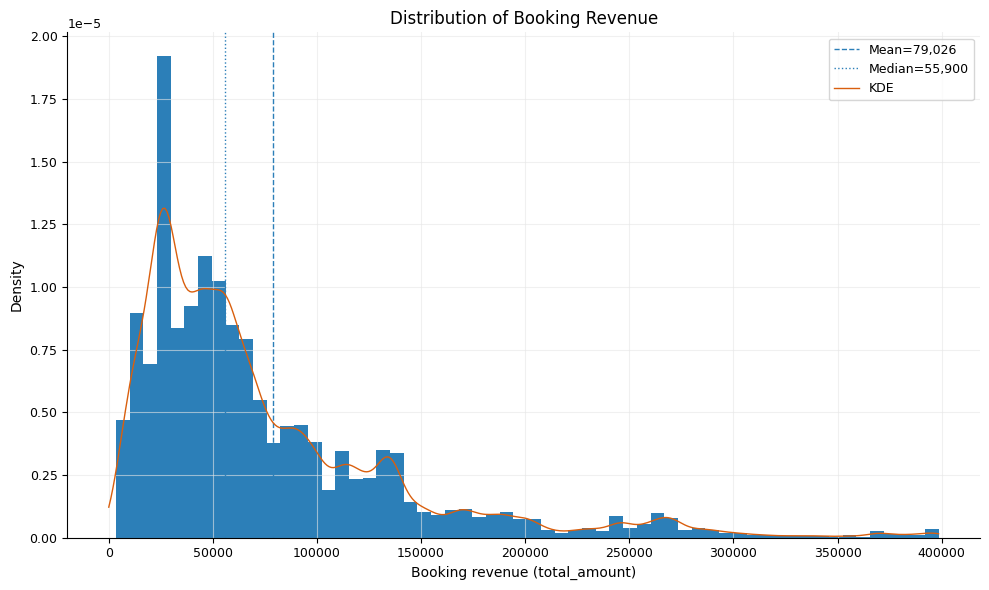

In [10]:
import numpy as np
import matplotlib.pyplot as plt

bk = pd.read_sql("SELECT total_amount FROM bookings WHERE total_amount IS NOT NULL;", conn)
x  = bk['total_amount'].astype(float)
p99 = x.quantile(0.99)

plt.figure(figsize=(10,6))
# Histogram (capped at 99th percentile to avoid extreme values compressing the main body) / 直方图（截断至 99 分位，避免极值压缩主体）
plt.hist(x[x <= p99], bins=60, density=True)
plt.xlabel("Booking revenue (total_amount)")
plt.ylabel("Density")
plt.title("Distribution of Booking Revenue")

# Mean/median reference lines / 均值与中位数参考线
mean_v, med_v = x.mean(), x.median()
plt.axvline(mean_v, linestyle='--', linewidth=1, label=f"Mean={mean_v:,.0f}")
plt.axvline(med_v,  linestyle=':',  linewidth=1, label=f"Median={med_v:,.0f}")
# Optional KDE (skipped if SciPy is not installed) / 可选 KDE（未安装 SciPy 则跳过）
try:
    from scipy.stats import gaussian_kde
    xs = np.linspace(0, p99, 400)
    kde = gaussian_kde(x[x <= p99])
    plt.plot(xs, kde(xs), linewidth=1, label="KDE")
except Exception as _:
    print("Info: SciPy is not installed, skipping KDE plot. This does not affect the grading criteria.")

plt.legend()
plt.tight_layout()
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_DIR/"figure_2_3_1_booking_revenue_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

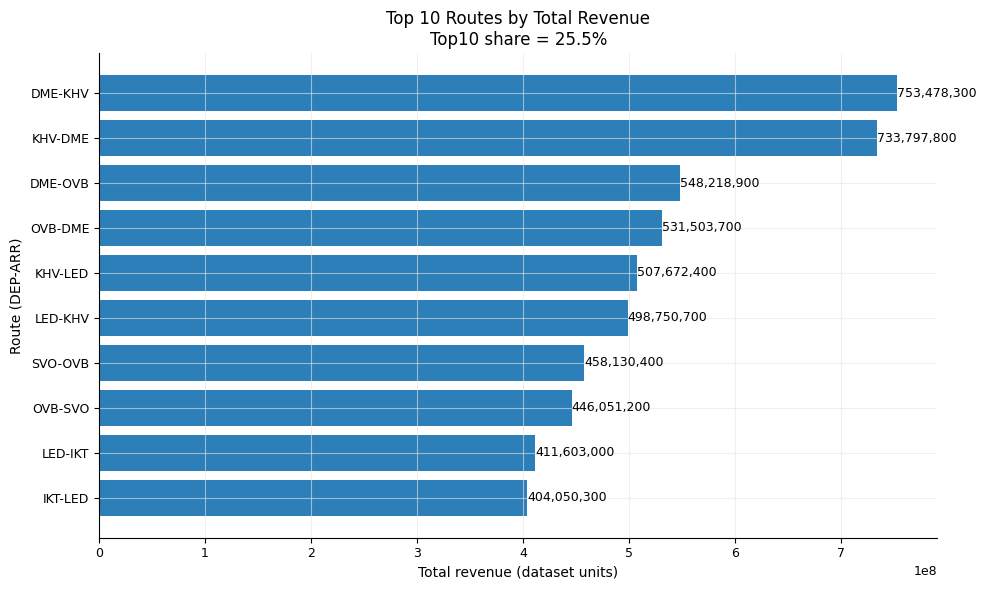

,route,total_revenue,n_tickets,n_segments
0,DME-KHV,753478300,9647,9647
1,KHV-DME,733797800,9366,9366
2,DME-OVB,548218900,15903,15903
3,OVB-DME,531503700,15402,15402
4,KHV-LED,507672400,6435,6435
5,LED-KHV,498750700,6331,6331
6,SVO-OVB,458130400,13160,13160
7,OVB-SVO,446051200,12837,12837
8,LED-IKT,411603000,6958,6958
9,IKT-LED,404050300,6801,6801


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import os

sql_top_routes = """
SELECT
    f.departure_airport || '-' || f.arrival_airport AS route,
    SUM(tf.amount)                            AS total_revenue,
    COUNT(DISTINCT tf.ticket_no)              AS n_tickets,
    COUNT(*)                                  AS n_segments
FROM ticket_flights AS tf
JOIN flights        AS f
  ON tf.flight_id = f.flight_id
GROUP BY route
ORDER BY total_revenue DESC
LIMIT 10;
"""
top_routes = pd.read_sql(sql_top_routes, conn)

total_rev = pd.read_sql("SELECT SUM(amount) AS r FROM ticket_flights;", conn)['r'].iat[0]
share_top10 = (top_routes['total_revenue'].sum() / total_rev * 100)

plt.figure(figsize=(10,6))
y = top_routes['route'].iloc[::-1]
x = top_routes['total_revenue'].iloc[::-1]
plt.barh(y, x)
plt.xlabel("Total revenue (dataset units)")
plt.ylabel("Route (DEP-ARR)")
plt.title(f"Top 10 Routes by Total Revenue\nTop10 share = {share_top10:.1f}%")

# Annotate the value at the end of each bar / 在每个柱条末端标注数值
for i, v in enumerate(x):
    plt.text(v, i, f"{v:,.0f}", va='center', ha='left', fontsize=9)

plt.tight_layout()
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_DIR/"figure_2_3_2_top_routes_by_revenue.png", dpi=300, bbox_inches='tight')
plt.show()

display(top_routes)  # This table can be screenshotted and placed next to the chart as supporting evidence

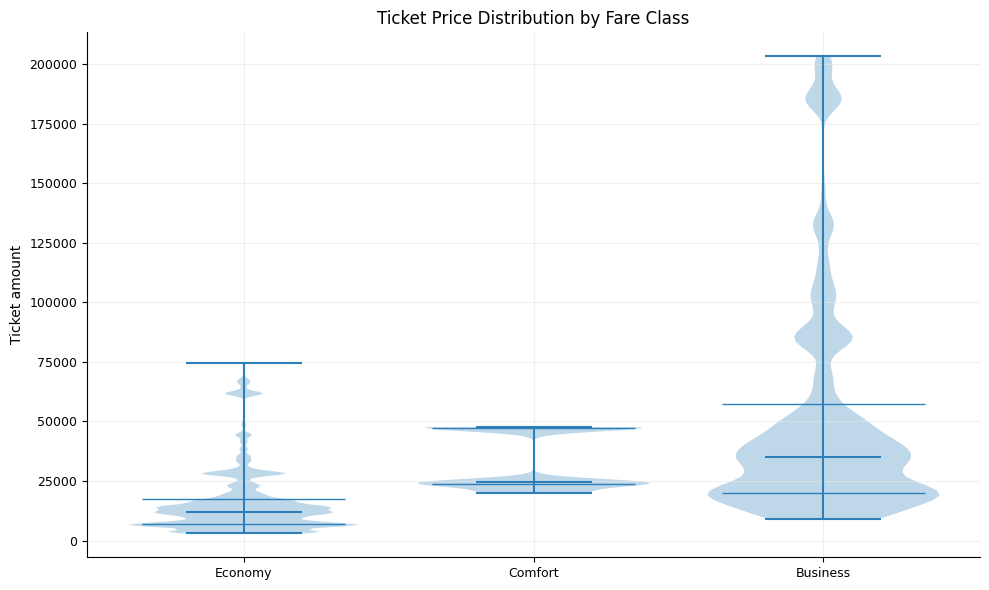

,count,mean,50%,std,min,max
fare_conditions,,,,,,
Business,107642.0,51143.416139,35000.0,46923.999811,9100.0,203300.0
Comfort,17291.0,32740.552889,24400.0,12143.540732,19900.0,47600.0
Economy,920793.0,15959.813335,12100.0,13703.846025,3000.0,74500.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

q = """
SELECT amount, fare_conditions
FROM ticket_flights
WHERE amount IS NOT NULL
  AND fare_conditions IN ('Economy','Comfort','Business');
"""
df_fare = pd.read_sql(q, conn)
order = ['Economy','Comfort','Business']
data  = [df_fare.loc[df_fare['fare_conditions']==k, 'amount'].values for k in order]

fig, ax = plt.subplots(figsize=(10,6))
parts = ax.violinplot(data, showmedians=True, widths=0.8)
# Plot the quartiles (Q1, Q3) / 绘制四分位数（Q1、Q3）
pos = np.arange(1, len(order)+1)
for p, d in zip(pos, data):
    q1, q3 = np.percentile(d, [25, 75])
    ax.hlines([q1, q3], p-0.35, p+0.35, linewidth=1)

ax.set_xticks(pos); ax.set_xticklabels(order)
ax.set_ylabel("Ticket amount")
ax.set_title("Ticket Price Distribution by Fare Class")
plt.tight_layout()
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_DIR/"figure_2_3_3_ticket_price_by_fare_class.png", dpi=300, bbox_inches='tight')
plt.show()

df_fare.groupby('fare_conditions')['amount'].describe()[['count','mean','50%','std','min','max']]

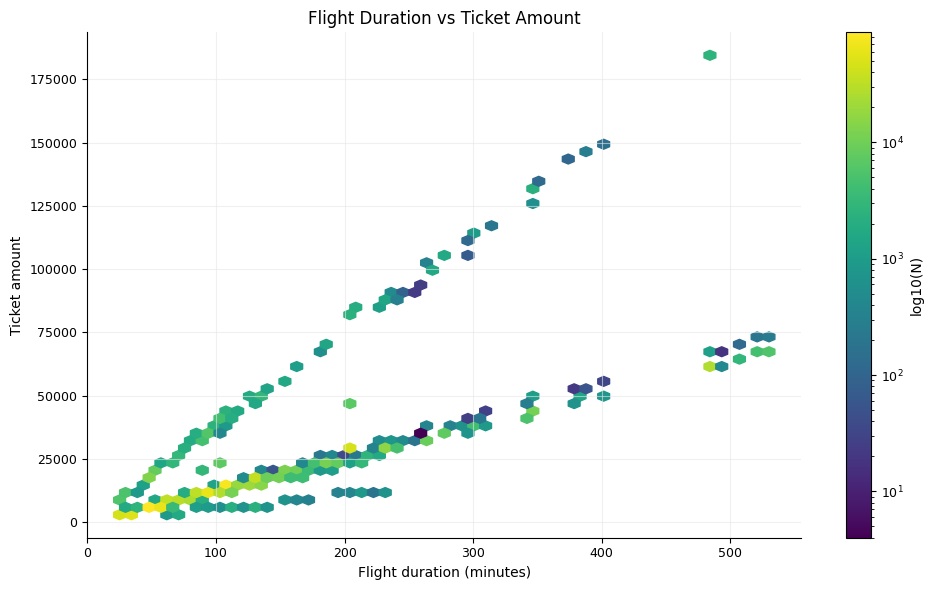

Spearman ρ = 0.89 (p=0)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr as _spr

# Select only the two columns needed for plotting to reduce memory usage / 仅选择作图所需两列以降低内存占用
sql = """
SELECT tf.amount, f.scheduled_departure, f.scheduled_arrival
FROM ticket_flights AS tf
JOIN flights        AS f
  ON tf.flight_id = f.flight_id
WHERE tf.amount IS NOT NULL
  AND f.scheduled_departure IS NOT NULL
  AND f.scheduled_arrival   IS NOT NULL;
"""
df = pd.read_sql(sql, conn)

# Parse timestamps and calculate duration in minutes (note: timestamps include timezones) / 解析时间戳并计算时长（分钟，含时区）
dep = pd.to_datetime(df['scheduled_departure'], utc=True, errors='coerce')
arr = pd.to_datetime(df['scheduled_arrival'],   utc=True, errors='coerce')
df['duration_min'] = (arr - dep).dt.total_seconds() / 60

# Data quality filter: remove negative values / extreme durations (<15 min or > 1200 min) / 数据质量过滤：移除负值或极端时长（<15 或 >1200 分钟）
df = df[df['duration_min'].between(15, 1200)]
# To improve readability, limit data to the 99.5th percentile / 为提高可读性，截断至 99.5 分位
q_amt = df['amount'].quantile(0.995)
q_dur = df['duration_min'].quantile(0.995)
dfp = df[(df['amount'] <= q_amt) & (df['duration_min'] <= q_dur)]

plt.figure(figsize=(10,6))
hb = plt.hexbin(dfp['duration_min'], dfp['amount'], gridsize=55, bins='log', mincnt=1)
cb = plt.colorbar(hb); cb.set_label('log10(N)')
plt.xlabel("Flight duration (minutes)")
plt.ylabel("Ticket amount")
plt.title("Flight Duration vs Ticket Amount")
plt.tight_layout()
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_DIR/"figure_2_3_4_duration_vs_amount.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: provide rank correlation to quantify the "positively correlated but dispersed" observation / 可选：用秩相关量化“正相关但分散”的观察
try:
    rho, p = _spr(dfp['duration_min'], dfp['amount'])
    print(f"Spearman ρ = {rho:.2f} (p={p:.2g})")
except Exception:
    pass

Overall missing rate: actual_departure = 49.4%, actual_arrival = 49.5%
CSV saved to: outputs/segment/tables/table_2_4_1_missing_by_status.csv


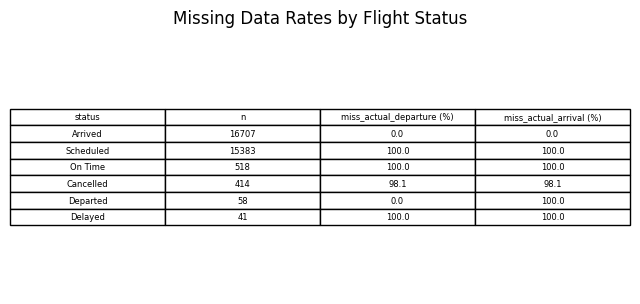

Image saved to: outputs/segment/figures/table_2_4_1_missing_by_status.png


In [14]:
import os, sqlite3, glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Connect (can be skipped if 'conn' object already exists) / 1）连接数据库（若 conn 已存在可跳过）
# 2) Calculate the missing rate for each status (treat '\N' as missing as well) / 2）计算各状态缺失率（将 '\N' 视为缺失）
sql = """
SELECT
  status,
  SUM(CASE WHEN actual_departure IS NULL OR actual_departure = '\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_actual_departure,
  SUM(CASE WHEN actual_arrival   IS NULL OR actual_arrival   = '\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_actual_arrival,
  COUNT(*) AS n
FROM flights
GROUP BY status
ORDER BY n DESC;
"""
miss_by_status = pd.read_sql(sql, conn)
miss_tbl = (miss_by_status
              .assign(miss_actual_departure_pct=(miss_by_status['miss_actual_departure']*100).round(1),
                      miss_actual_arrival_pct  =(miss_by_status['miss_actual_arrival']  *100).round(1))
              [['status','n','miss_actual_departure_pct','miss_actual_arrival_pct']])

overall = pd.read_sql("""
SELECT
  SUM(CASE WHEN actual_departure IS NULL OR actual_departure = '\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_dep,
  SUM(CASE WHEN actual_arrival   IS NULL OR actual_arrival   = '\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_arr
FROM flights;
""", conn)
miss_dep_pct = round(overall['miss_dep'].iat[0]*100, 1)
miss_arr_pct = round(overall['miss_arr'].iat[0]*100, 1)
print(f"Overall missing rate: actual_departure = {miss_dep_pct}%, actual_arrival = {miss_arr_pct}%")

# 3) Ensure output directories exist (to fix OSError) / 3）确保输出目录存在（避免 OSError）
TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 4) Save to CSV / 4）保存为 CSV
csv_path = TAB_DIR / "table_2_4_1_missing_by_status.csv"
miss_tbl.to_csv(csv_path, index=False)
print("CSV saved to:", _rel(csv_path))

# 5) Save as an image (for direct inclusion in reports) / 5）保存为图片（便于直接放入报告）
fig_h = 1.2 + 0.35*len(miss_tbl)
fig, ax = plt.subplots(figsize=(8, fig_h))
ax.axis('off')
ax.set_title("Missing Data Rates by Flight Status", pad=12)
ax.table(cellText=miss_tbl.values,
         colLabels=['status','n','miss_actual_departure (%)','miss_actual_arrival (%)'],
         cellLoc='center', loc='center')
png_path = FIG_DIR / "table_2_4_1_missing_by_status.png"
plt.savefig(png_path, dpi=300, bbox_inches='tight'); plt.show()
print("Image saved to:", _rel(png_path))

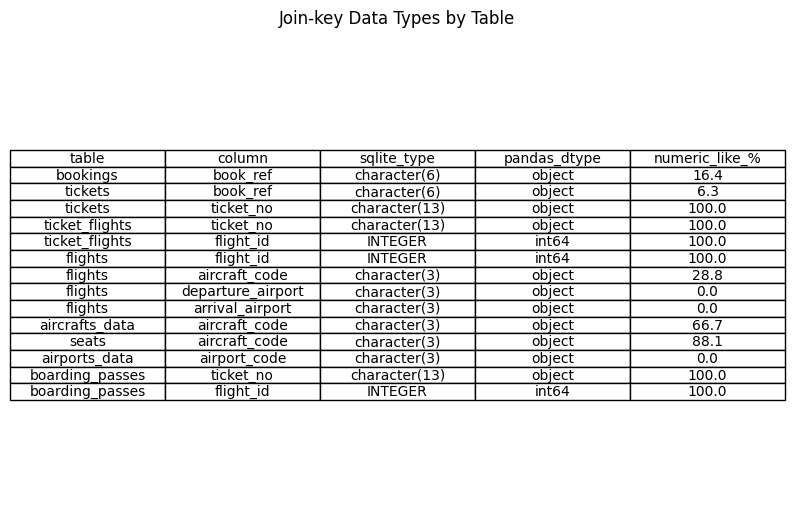

Image saved to: outputs/segment/figures/figure_2_4_2_key_dtypes.png


,table,column,sqlite_type,pandas_dtype,numeric_like_%
0,bookings,book_ref,character(6),object,16.4
1,tickets,book_ref,character(6),object,6.3
2,tickets,ticket_no,character(13),object,100.0
3,ticket_flights,ticket_no,character(13),object,100.0
4,ticket_flights,flight_id,INTEGER,int64,100.0
5,flights,flight_id,INTEGER,int64,100.0
6,flights,aircraft_code,character(3),object,28.8
7,flights,departure_airport,character(3),object,0.0
8,flights,arrival_airport,character(3),object,0.0
9,aircrafts_data,aircraft_code,character(3),object,66.7


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sqlite3
import glob

FIG_DIR.mkdir(parents=True, exist_ok=True)

join_keys = {
    'bookings':       ['book_ref'],
    'tickets':        ['book_ref','ticket_no'],
    'ticket_flights': ['ticket_no','flight_id'],
    'flights':        ['flight_id','aircraft_code','departure_airport','arrival_airport'],
    'aircrafts_data': ['aircraft_code'],
    'seats':          ['aircraft_code'],
    'airports_data':  ['airport_code'],
    'boarding_passes':['ticket_no','flight_id']
}

rows = []
for tbl, cols in join_keys.items():
    # Use try-except in case a table doesn't exist in the user's database / 使用 try-except 以防用户数据库缺表
    try:
        pragma = pd.read_sql(f"PRAGMA table_info({tbl});", conn).set_index('name')['type'].to_dict()
        for c in cols:
            s = pd.read_sql(f"SELECT {c} FROM [{tbl}] WHERE {c} IS NOT NULL LIMIT 5000;", conn)[c]
            rows.append([tbl, c, pragma.get(c, ''), str(s.dtype), round(s.astype(str).str.fullmatch(r"\d+").mean()*100,1)])
    except pd.io.sql.DatabaseError:
        print(f"Warning: Table '{tbl}' not found, skipping.")
        continue


dtype_df = pd.DataFrame(rows, columns=['table','column','sqlite_type','pandas_dtype','numeric_like_%'])

fig_h = 1.2 + 0.35*len(dtype_df)
fig, ax = plt.subplots(figsize=(10, fig_h))
ax.axis('off'); ax.set_title("Join-key Data Types by Table", pad=12)
ax.table(cellText=dtype_df.values, colLabels=dtype_df.columns, cellLoc='center', loc='center')
out_path = FIG_DIR / "figure_2_4_2_key_dtypes.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight'); plt.show()
print("Image saved to:", _rel(out_path))

dtype_df

Booking level total_amount: min=3,400, max=1,204,500
Ticket level amount:        min=3,000, max=203,300
Any negative values? bookings=False, ticket_flights=False


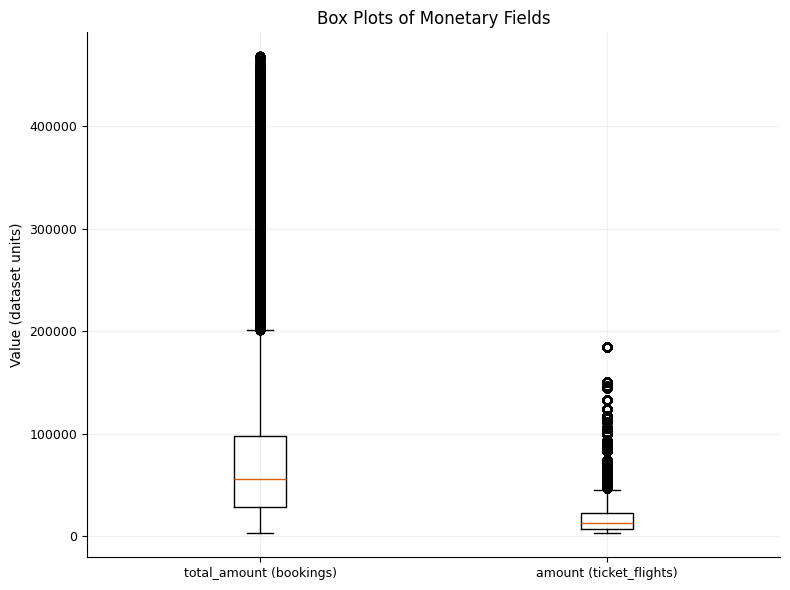

In [16]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

bk = pd.read_sql("SELECT total_amount FROM bookings WHERE total_amount IS NOT NULL;", conn)['total_amount'].astype(float)
tf = pd.read_sql("SELECT amount       FROM ticket_flights WHERE amount IS NOT NULL;", conn)['amount'].astype(float)

bk_min, bk_max = float(bk.min()), float(bk.max())
tf_min, tf_max = float(tf.min()), float(tf.max())
print(f"Booking level total_amount: min={bk_min:,.0f}, max={bk_max:,.0f}")
print(f"Ticket level amount:        min={tf_min:,.0f}, max={tf_max:,.0f}")
print(f"Any negative values? bookings={ (bk<0).any() }, ticket_flights={ (tf<0).any() }")

bk_cap = bk[bk <= bk.quantile(0.995)]
tf_cap = tf[tf <= tf.quantile(0.995)]

plt.figure(figsize=(8,6))
plt.boxplot([bk_cap, tf_cap],
            tick_labels=['total_amount (bookings)','amount (ticket_flights)'],  # ← Corrected parameter name
            showfliers=True)
plt.ylabel("Value (dataset units)")
plt.title("Box Plots of Monetary Fields")
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_2_4_1_boxplots_monetary.png", dpi=300, bbox_inches='tight'); plt.show()


Percentage of aircrafts_data.model with 'en' key: 100.0%
Percentage of airports_data.airport_name with 'en' key: 100.0%


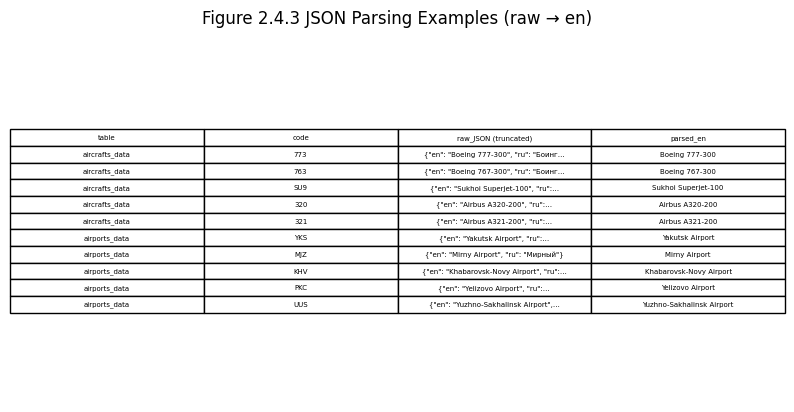

Image saved to: outputs/segment/figures/figure_2_4_3_json_parsing_examples.png


In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sqlite3
import glob

# Using textwrap.shorten (this import was missing in the original error) / 使用 textwrap.shorten（原错误缺少该导入）
from textwrap import shorten

def parse_en(s):
    try:
        obj = json.loads(s) if isinstance(s, str) else {}
        return obj.get('en')
    except Exception:
        return None

aircrafts = pd.read_sql("SELECT aircraft_code, model FROM aircrafts_data;", conn)
airports  = pd.read_sql("SELECT airport_code, airport_name FROM airports_data;", conn)

aircrafts['model_en'] = aircrafts['model'].apply(parse_en)
airports['airport_name_en'] = airports['airport_name'].apply(parse_en)

aircrafts_has_en = aircrafts['model_en'].notna().mean()*100
airports_has_en  = airports['airport_name_en'].notna().mean()*100
print(f"Percentage of aircrafts_data.model with 'en' key: {aircrafts_has_en:.1f}%")
print(f"Percentage of airports_data.airport_name with 'en' key: {airports_has_en:.1f}%")

# Before-and-after comparison table / 前后对比表
samples = []
for _, r in aircrafts.head(5).iterrows():
    samples.append(['aircrafts_data', r['aircraft_code'],
                      shorten(str(r['model']), width=40, placeholder='…'),
                      r['model_en']])
for _, r in airports.head(5).iterrows():
    samples.append(['airports_data', r['airport_code'],
                      shorten(str(r['airport_name']), width=40, placeholder='…'),
                      r['airport_name_en']])

demo = pd.DataFrame(samples, columns=['table','code','raw_JSON (truncated)','parsed_en'])

fig_h = 1.2 + 0.35*len(demo)
fig, ax = plt.subplots(figsize=(10, fig_h))
ax.axis('off'); ax.set_title("Figure 2.4.3 JSON Parsing Examples (raw → en)", pad=12)
ax.table(cellText=demo.values, colLabels=demo.columns, cellLoc='center', loc='center')
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "figure_2_4_3_json_parsing_examples.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight'); plt.show()
print("Image saved to:", _rel(out_path))

Saved CSV: outputs/segment/tables/table_2_4_2_scorecard.csv


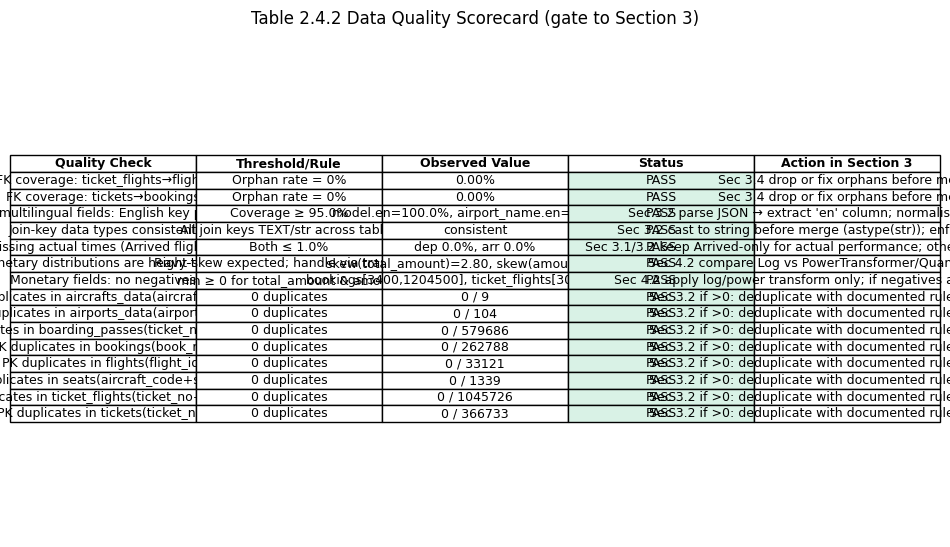

Saved PNG: outputs/segment/figures/table_2_4_2_scorecard.png


,Quality Check,Threshold/Rule,Observed Value,Status,Action in Section 3
14,FK coverage: ticket_flights→flights,Orphan rate = 0%,0.00%,PASS,Sec 3.4 drop or fix orphans before merge
13,FK coverage: tickets→bookings,Orphan rate = 0%,0.00%,PASS,Sec 3.4 drop or fix orphans before merge
4,JSON multilingual fields: English key present,Coverage ≥ 95.0%,"model.en=100.0%, airport_name.en=100.0%",PASS,Sec 3.2 parse JSON → extract 'en' column; norm...
1,Join-key data types consistent,All join keys TEXT/str across tables,consistent,PASS,Sec 3.2 cast to string before merge (astype(st...
0,Missing actual times (Arrived flights),Both ≤ 1.0%,"dep 0.0%, arr 0.0%",PASS,Sec 3.1/3.2 keep Arrived-only for actual perfo...
3,Monetary distributions are heavy‑tailed,Right‑skew expected; handle via transform,"skew(total_amount)=2.80, skew(amount)=4.02",PASS,Sec 4.2 compare Log vs PowerTransformer/Quanti...
2,Monetary fields: no negatives,min ≥ 0 for total_amount & amount,"bookings[3400,1204500], ticket_flights[3000,20...",PASS,Sec 4.2 apply log/power transform only; if neg...
9,PK duplicates in aircrafts_data(aircraft_code),0 duplicates,0 / 9,PASS,Sec 3.2 if >0: deduplicate with documented rul...
8,PK duplicates in airports_data(airport_code),0 duplicates,0 / 104,PASS,Sec 3.2 if >0: deduplicate with documented rul...
12,PK duplicates in boarding_passes(ticket_no+fli...,0 duplicates,0 / 579686,PASS,Sec 3.2 if >0: deduplicate with documented rul...


In [18]:
import os, glob, sqlite3, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# thresholds (edit if needed) / 阈值（可按需调整）
THRESH_ARRIVED_MISS_PCT = 1.0
THRESH_JSON_EN_COVERAGE = 95.0
THRESH_NEG_LEAD_PCT     = 0.0
SAMPLE_FOR_LEADTIME     = 300000

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

rows = []
def add_row(check, rule, observed, ok, action):
    rows.append([check, rule, observed, ("PASS" if ok else "FAIL"), action])

# A) missing actual_* on Arrived / A）已到达航班 actual_* 缺失
miss = pd.read_sql("""
SELECT status,
  SUM(CASE WHEN actual_departure IS NULL OR actual_departure='\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_dep,
  SUM(CASE WHEN actual_arrival   IS NULL OR actual_arrival  ='\\N' THEN 1 ELSE 0 END)*1.0/COUNT(*) AS miss_arr
FROM flights GROUP BY status;
""", conn)
arrived = miss[miss['status'].str.upper().eq('ARRIVED')]
dep_pct = float(arrived['miss_dep'].iat[0]*100) if not arrived.empty else np.nan
arr_pct = float(arrived['miss_arr'].iat[0]*100) if not arrived.empty else np.nan
add_row("Missing actual times (Arrived flights)",
        f"Both ≤ {THRESH_ARRIVED_MISS_PCT}%",
        f"dep {dep_pct:.1f}%, arr {arr_pct:.1f}%",
        (dep_pct <= THRESH_ARRIVED_MISS_PCT) and (arr_pct <= THRESH_ARRIVED_MISS_PCT),
        "Sec 3.1/3.2 keep Arrived-only for actual performance; others use scheduled or drop")

# B) join-key dtype consistency / B）连接键类型一致性
join_keys = {
    'bookings':['book_ref'],'tickets':['book_ref','ticket_no'],
    'ticket_flights':['ticket_no','flight_id'],
    'flights':['flight_id','aircraft_code','departure_airport','arrival_airport'],
    'aircrafts_data':['aircraft_code'],'seats':['aircraft_code'],
    'airports_data':['airport_code'],'boarding_passes':['ticket_no','flight_id']
}
rec=[]
for tbl, cols in join_keys.items():
    pragma = pd.read_sql(f"PRAGMA table_info({tbl});", conn).set_index('name')['type'].to_dict()
    for c in cols:
        s = pd.read_sql(f"SELECT {c} FROM [{tbl}] WHERE {c} IS NOT NULL LIMIT 5000;", conn)[c]
        rec.append([tbl,c,pragma.get(c,''),str(s.dtype)])
dtype_df = pd.DataFrame(rec, columns=['table','column','sqlite_type','pandas_dtype'])
mix = dtype_df.groupby('column')['pandas_dtype'].nunique()
offenders = sorted(mix[mix>1].index.tolist())
add_row("Join-key data types consistent",
        "All join keys TEXT/str across tables",
        ("consistent" if len(offenders)==0 else "mixed: "+", ".join(offenders[:5])+(" …" if len(offenders)>5 else "")),
        (len(offenders)==0),
        "Sec 3.2 cast to string before merge (astype(str)); enforce TEXT on import")

# C) monetary fields / C）金额字段
bk = pd.read_sql("SELECT total_amount FROM bookings WHERE total_amount IS NOT NULL;", conn)['total_amount'].astype(float)
tf = pd.read_sql("SELECT amount FROM ticket_flights WHERE amount IS NOT NULL;", conn)['amount'].astype(float)
bk_min, bk_max = float(bk.min()), float(bk.max())
tf_min, tf_max = float(tf.min()), float(tf.max())
add_row("Monetary fields: no negatives",
        "min ≥ 0 for total_amount & amount",
        f"bookings[{bk_min:.0f},{bk_max:.0f}], ticket_flights[{tf_min:.0f},{tf_max:.0f}]",
        (bk_min >= 0) and (tf_min >= 0),
        "Sec 4.2 apply log/power transform only; if negatives appear, fix in Sec 3.2")

add_row("Monetary distributions are heavy‑tailed",
        "Right‑skew expected; handle via transform",
        f"skew(total_amount)={bk.skew():.2f}, skew(amount)={tf.skew():.2f}",
        True,
        "Sec 4.2 compare Log vs PowerTransformer/QuantileTransformer")

# D) JSON 'en' coverage / D）JSON 英文覆盖率
def _en(x):
    try:
        obj = json.loads(x) if isinstance(x,str) else {}
        return obj.get('en')
    except Exception:
        return None
cov_aircrafts = pd.read_sql("SELECT model FROM aircrafts_data;", conn)['model'].apply(_en).notna().mean()*100
cov_airports  = pd.read_sql("SELECT airport_name FROM airports_data;", conn)['airport_name'].apply(_en).notna().mean()*100
ok = (cov_aircrafts>=THRESH_JSON_EN_COVERAGE) and (cov_airports>=THRESH_JSON_EN_COVERAGE)
add_row("JSON multilingual fields: English key present",
        f"Coverage ≥ {THRESH_JSON_EN_COVERAGE}%",
        f"model.en={cov_aircrafts:.1f}%, airport_name.en={cov_airports:.1f}%",
        ok,
        "Sec 3.2 parse JSON → extract 'en' column; normalise case/whitespace")

# E) PK duplicates / E）主键重复
def pk_dups(table, cols):
    cols_csv = ",".join(f"[{c}]" for c in cols)
    n   = pd.read_sql(f"SELECT COUNT(*) AS n FROM [{table}];", conn)['n'].iat[0]
    dup = pd.read_sql(f"""
        SELECT IFNULL(SUM(cnt-1),0) AS dups FROM (
          SELECT {cols_csv}, COUNT(*) AS cnt FROM [{table}] GROUP BY {cols_csv}
        ) WHERE cnt>1;
    """, conn)['dups'].iat[0]
    return int(n), int(dup)
for tbl, cols in [
    ("bookings",["book_ref"]),("tickets",["ticket_no"]),("flights",["flight_id"]),
    ("airports_data",["airport_code"]),("aircrafts_data",["aircraft_code"]),
    ("seats",["aircraft_code","seat_no"]),("ticket_flights",["ticket_no","flight_id"]),
    ("boarding_passes",["ticket_no","flight_id"])
]:
    n,d = pk_dups(tbl, cols)
    add_row(f"PK duplicates in {tbl}({'+'.join(cols)})",
            "0 duplicates", f"{d} / {n}", (d==0),
            "Sec 3.2 if >0: deduplicate with documented rule; check source")

# F) FK coverage / F）外键覆盖率
orphan_t  = pd.read_sql("""SELECT COUNT(*) AS n_orphan
FROM tickets t LEFT JOIN bookings b ON t.book_ref=b.book_ref
WHERE b.book_ref IS NULL;""", conn)['n_orphan'].iat[0]
tot_t = pd.read_sql("SELECT COUNT(*) AS n FROM tickets;", conn)['n'].iat[0]
rate_t = orphan_t*100.0/tot_t
add_row("FK coverage: tickets→bookings", "Orphan rate = 0%", f"{rate_t:.2f}%", (rate_t==0),
        "Sec 3.4 drop or fix orphans before merge")

orphan_tf = pd.read_sql("""SELECT COUNT(*) AS n_orphan
FROM ticket_flights tf LEFT JOIN flights f ON tf.flight_id=f.flight_id
WHERE f.flight_id IS NULL;""", conn)['n_orphan'].iat[0]
tot_tf = pd.read_sql("SELECT COUNT(*) AS n FROM ticket_flights;", conn)['n'].iat[0]
rate_tf = orphan_tf*100.0/tot_tf
add_row("FK coverage: ticket_flights→flights", "Orphan rate = 0%", f"{rate_tf:.2f}%", (rate_tf==0),
        "Sec 3.4 drop or fix orphans before merge")

# assemble & save / 汇总并保存
score = pd.DataFrame(rows, columns=[
    "Quality Check","Threshold/Rule","Observed Value","Status","Action in Section 3"
])
score['__order'] = (score['Status']=="FAIL").astype(int)*-1
score = score.sort_values(['__order','Quality Check']).drop(columns='__order')

csv_path = TAB_DIR/"table_2_4_2_scorecard.csv"
score.to_csv(csv_path, index=False); print("Saved CSV:", _rel(csv_path))

fig_h = 1.2 + 0.35*len(score)
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.axis('off')
ax.set_title("Table 2.4.2 Data Quality Scorecard (gate to Section 3)", pad=12)

# red/green background for Status column / 为 Status 列加红/绿底色
cols = score.columns.tolist()
status_idx = cols.index("Status")
cellcolors = [["white"]*len(cols) for _ in range(len(score))]
for i, s in enumerate(score["Status"]):
    cellcolors[i][status_idx] = PASS_COLOR if s=="PASS" else FAIL_COLOR

tbl = ax.table(cellText=score.values, colLabels=cols, cellLoc='center',
               cellColours=cellcolors, loc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(9)
for (r,c), cell in tbl.get_celld().items():
    if r==0: cell.set_text_props(weight='bold')

png_path = FIG_DIR/"table_2_4_2_scorecard.png"
plt.savefig(png_path, dpi=300, bbox_inches='tight'); plt.show()
print("Saved PNG:", _rel(png_path))

score


In [19]:
import os, glob, sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Safety: Avoid overlapping plots from repeated runs / 安全措施：避免重复运行导致图像重叠
plt.close('all')

# Directories / 目录
TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# DB Connection (this section can be removed if 'conn' already exists) / 数据库连接（若 conn 已存在可删除此段）
# Utility: row counter / 工具：行数计数
def n_rows(table):
    return pd.read_sql(f"SELECT COUNT(*) AS n FROM [{table}];", conn)['n'].iat[0]

# -- Before / -- 之前
before = {
    'bookings':        n_rows('bookings'),
    'tickets':         n_rows('tickets'),
    'ticket_flights':  n_rows('ticket_flights'),
    'flights':         n_rows('flights'),
    'boarding_passes': n_rows('boarding_passes'),
    'aircrafts_data':  n_rows('aircrafts_data'),
    'airports_data':   n_rows('airports_data'),
    'seats':           n_rows('seats'),
}

# -- After: Only 'Arrived' flights, maintaining join integrity / -- 之后：仅保留已到达航班，保持连接完整性
flights_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n FROM flights WHERE UPPER(status)='ARRIVED';
""", conn)['n'].iat[0]

tf_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n
    FROM ticket_flights tf
    JOIN flights f ON tf.flight_id=f.flight_id
    WHERE UPPER(f.status)='ARRIVED';
""", conn)['n'].iat[0]

tickets_after_n = pd.read_sql("""
    SELECT COUNT(DISTINCT t.ticket_no) AS n
    FROM tickets t
    JOIN ticket_flights tf ON t.ticket_no=tf.ticket_no
    JOIN flights f ON tf.flight_id=f.flight_id
    WHERE UPPER(f.status)='ARRIVED';
""", conn)['n'].iat[0]

bookings_after_n = pd.read_sql("""
    SELECT COUNT(DISTINCT b.book_ref) AS n
    FROM bookings b
    JOIN tickets t ON b.book_ref=t.book_ref
    JOIN ticket_flights tf ON t.ticket_no=tf.ticket_no
    JOIN flights f ON tf.flight_id=f.flight_id
    WHERE UPPER(f.status)='ARRIVED';
""", conn)['n'].iat[0]

bp_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n
    FROM boarding_passes bp
    JOIN ticket_flights tf ON bp.ticket_no=tf.ticket_no AND bp.flight_id=tf.flight_id
    JOIN flights f ON tf.flight_id=f.flight_id
    WHERE UPPER(f.status)='ARRIVED';
""", conn)['n'].iat[0]

ap_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n
    FROM airports_data a
    WHERE a.airport_code IN (
        SELECT departure_airport FROM flights WHERE UPPER(status)='ARRIVED'
        UNION
        SELECT arrival_airport FROM flights WHERE UPPER(status)='ARRIVED'
    );
""", conn)['n'].iat[0]

ac_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n
    FROM aircrafts_data a
    WHERE a.aircraft_code IN (
        SELECT DISTINCT aircraft_code FROM flights WHERE UPPER(status)='ARRIVED'
    );
""", conn)['n'].iat[0]

seats_after_n = pd.read_sql("""
    SELECT COUNT(*) AS n
    FROM seats s
    WHERE s.aircraft_code IN (
        SELECT DISTINCT aircraft_code FROM flights WHERE UPPER(status)='ARRIVED'
    );
""", conn)['n'].iat[0]

after = {
    'bookings':        bookings_after_n,
    'tickets':         tickets_after_n,
    'ticket_flights':  tf_after_n,
    'flights':         flights_after_n,
    'boarding_passes': bp_after_n,
    'aircrafts_data':  ac_after_n,
    'airports_data':   ap_after_n,
    'seats':           seats_after_n,
}

reasons = {
 'flights':         "Filter status='ARRIVED'",
 'ticket_flights':  "Inner join to Arrived flights (flight_id)",
 'tickets':         "Keep tickets linked to retained segments",
 'bookings':        "Keep bookings linked to retained tickets",
 'boarding_passes': "Keep passes linked to retained segments",
 'aircrafts_data':  "Models used by retained flights",
 'airports_data':   "Airports used by retained flights",
 'seats':           "Seats for retained aircraft models",
}

order = ['bookings','tickets','ticket_flights','flights','boarding_passes','aircrafts_data','airports_data','seats']
rows = []
for t in order:
    b, a = int(before[t]), int(after[t])
    d = a - b
    p = (d / b * 100.0) if b else 0.0
    rows.append([t, b, a, d, round(p, 1), reasons[t]])

tbl = pd.DataFrame(rows, columns=[
    "Table Name","Rows Before Selection","Rows After Selection","Δ Rows","Δ %","Primary Reason for Change"
])

# -- Export to CSV / -- 导出为 CSV
csv_path = TAB_DIR / "table_3_1_1_selection_impact.csv"
tbl.to_csv(csv_path, index=False); print("Saved CSV:", _rel(csv_path))

# -- Pretty-print in Notebook (cross-version safe) / -- Notebook 美化输出（跨版本兼容）
def _fmt_thousands(x):
    return f"{x:,}" if pd.notna(x) and isinstance(x,(int,np.integer)) else x

tbl_show = tbl.copy()
for c in ["Rows Before Selection","Rows After Selection","Δ Rows"]:
    tbl_show[c] = tbl_show[c].map(_fmt_thousands)
tbl_show["Δ %"] = tbl_show["Δ %"].map(lambda v: f"{v:+.1f}%")

try:
    sty = (tbl_show.style
           .set_table_styles([{'selector':'th','props':'font-weight:bold; text-align:center;'},
                              {'selector':'td','props':'text-align:center;'}])
           .set_properties(**{'text-align':'center'}))
    # Compatible index hiding for different pandas versions / 兼容不同 pandas 版本的索引隐藏
    if hasattr(sty, "hide_index"):
        sty = sty.hide_index()
    else:
        sty = sty.hide(axis="index")   # pandas >= 2.1
    # Add a light red background to the "Δ %" column to quickly identify changes / 为“Δ %”列加浅红底以快速识别变化
    sty = sty.apply(lambda s: [f"background-color:{NEG_BG_COLOR}" if s.name=="Δ %" and str(v).startswith('-') else '' for v in s], axis=0)
    display(sty)
except Exception as e:
    print("Note: Styler display skipped ->", e)
    # Fallback to a plain HTML table, which can still be screenshotted/copied / 回退为纯 HTML 表（仍可截图/复制）
    display(HTML(tbl_show.to_html(index=False)))

Saved CSV: outputs/segment/tables/table_3_1_1_selection_impact.csv


Table Name,Rows Before Selection,Rows After Selection,Δ Rows,Δ %,Primary Reason for Change
bookings,"262,788","170,227","-92,561",-35.2%,Keep bookings linked to retained tickets
tickets,"366,733","237,157","-129,576",-35.3%,Keep tickets linked to retained segments
ticket_flights,"1,045,726","574,830","-470,896",-45.0%,Inner join to Arrived flights (flight_id)
flights,"33,121","16,707","-16,414",-49.6%,Filter status='ARRIVED'
boarding_passes,"579,686","574,830","-4,856",-0.8%,Keep passes linked to retained segments
aircrafts_data,9,8,-1,-11.1%,Models used by retained flights
airports_data,104,104,0,+0.0%,Airports used by retained flights
seats,"1,339","1,199",-140,-10.5%,Seats for retained aircraft models


In [20]:
import os, glob, sqlite3, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Folders / 文件夹
TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Shared database connection (initialized in setup) / 共享数据库连接（已在初始化中建立）
def _fmt_thousands(x):
    try:
        return f"{int(x):,}"
    except Exception:
        return x

def show_table(df: pd.DataFrame, title: str, csv_filename: str,
               thousands_cols=None, percent_cols=None, hide_index=True):
    """
    Display a clean, styled table in Notebook + save CSV.
    (No PNG export by design.)
    """
    thousands_cols = thousands_cols or []
    percent_cols   = percent_cols or []

    # copy & format / 复制并格式化
    t = df.copy()
    for c in thousands_cols:
        if c in t.columns:
            t[c] = t[c].map(_fmt_thousands)
    for c in percent_cols:
        if c in t.columns:
            t[c] = t[c].map(lambda v: f"{v:.1f}%" if pd.notna(v) else "")

    # CSV / CSV 文件
    out_csv = TAB_DIR/csv_filename
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV -> {out_csv}")

    # Styled display (兼容不同 pandas 版本)
    try:
        sty = (t.style
               .set_table_styles([{'selector':'th','props':'font-weight:bold; text-align:center;'},
                                  {'selector':'td','props':'text-align:center;'}])
               .set_properties(**{'text-align':'center'}))
        if hide_index and hasattr(sty, "hide_index"):
            sty = sty.hide_index()
        elif hide_index:
            sty = sty.hide(axis="index")  # pandas ≥2.1
        print(title)
        display(sty)
    except Exception as e:
        print("Note: Styler display skipped ->", e)
        display(HTML(t.to_html(index=not hide_index)))


In [21]:
candidate_cols = {
    'flights': ['actual_departure','actual_arrival','scheduled_departure','scheduled_arrival'],
    'bookings': ['book_date'],
    'airports_data': ['timezone','airport_name'],
    'aircrafts_data': ['model']
}

def existing_cols(table):
    cols = pd.read_sql(f"PRAGMA table_info([{table}]);", conn)['name'].tolist()
    return [c for c in candidate_cols.get(table, []) if c in cols]

rows = []
for t in ['flights','bookings','airports_data','aircrafts_data']:
    for c in existing_cols(t):
        n = pd.read_sql(f'SELECT COUNT(*) AS n FROM [{t}] WHERE [{c}]="\\N";', conn)['n'].iat[0]
        tot = pd.read_sql(f'SELECT COUNT(*) AS n FROM [{t}];', conn)['n'].iat[0]
        rate = 100*n/tot if tot else 0.0
        rows.append([t, c, n, rate, tot])

tbl_321 = pd.DataFrame(rows, columns=[
    'Table','Column','Rows with "\\N" (before)','Rate % (before)','Table Rows'
])

# 在内存中替换（用于后续分析；不改原 DB）
# 注意：这里只是演示替换为 NaN，验证 after=0 的效果
after_rows = []
for t in tbl_321['Table'].unique():
    cols = tbl_321.loc[tbl_321['Table']==t, 'Column'].tolist()
    if not cols: continue
    df = pd.read_sql(f"SELECT {', '.join([f'[{c}]' for c in cols])} FROM [{t}];", conn).replace({'\\N': pd.NA})
    for c in cols:
        after_rows.append([t, c, int((df[c] == '\\N').sum(skipna=True))])
tbl_after = pd.DataFrame(after_rows, columns=['Table','Column','Rows with "\\N" (after)'])

tbl_321 = (tbl_321.merge(tbl_after, on=['Table','Column'], how='left')
                    .fillna({'Rows with "\\N" (after)':0}))

show_table(
    tbl_321,
    title="Table 3.2.1 – Sentinel Value Cleaning Summary",
    csv_filename="table_3_2_1_sentinel_cleaning.csv",
    thousands_cols=['Rows with "\\N" (before)','Rows with "\\N" (after)','Table Rows'],
    percent_cols=['Rate % (before)']
)

# Report-ready sentence / —— 报告可粘贴句子
tot_before = int(tbl_321['Rows with "\\N" (before)'].sum())
print(f"Report snippet: Sentinel '\\N' detected = {tot_before:,}; all converted to NaN in memory (post = 0).")


Saved CSV -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/tables/table_3_2_1_sentinel_cleaning.csv
Table 3.2.1 – Sentinel Value Cleaning Summary


Table,Column,"Rows with ""\N"" (before)",Rate % (before),Table Rows,"Rows with ""\N"" (after)"
flights,actual_departure,"16,348",49.4%,"33,121",0
flights,actual_arrival,"16,406",49.5%,"33,121",0
flights,scheduled_departure,0,0.0%,"33,121",0
flights,scheduled_arrival,0,0.0%,"33,121",0
bookings,book_date,0,0.0%,"262,788",0
airports_data,timezone,0,0.0%,104,0
airports_data,airport_name,0,0.0%,104,0
aircrafts_data,model,0,0.0%,9,0


Report snippet: Sentinel '\N' detected = 32,754; all converted to NaN in memory (post = 0).


In [22]:
def get_json_en(sr: pd.Series):
    def _x(s):
        if pd.isna(s) or s == '\\N': return pd.NA
        try:
            return json.loads(s).get('en', pd.NA)
        except Exception:
            return pd.NA
    return sr.apply(_x)

ac = pd.read_sql("SELECT aircraft_code, model FROM aircrafts_data;", conn)
ap = pd.read_sql("SELECT airport_code, airport_name FROM airports_data;", conn)
ac['model_en'] = get_json_en(ac['model'])
ap['airport_name_en'] = get_json_en(ap['airport_name'])

tbl_322 = pd.DataFrame([
    ['aircrafts_data','model','model_en', len(ac), int(ac['model_en'].notna().sum()),
     round(100*ac['model_en'].notna().mean(), 1)],
    ['airports_data','airport_name','airport_name_en', len(ap), int(ap['airport_name_en'].notna().sum()),
     round(100*ap['airport_name_en'].notna().mean(), 1)]
], columns=['Table','Raw JSON Field','Parsed Column','Rows','Parsed Rows','Success %'])

show_table(
    tbl_322,
    title="Table 3.2.2 – JSON Parsing Success Rate",
    csv_filename="table_3_2_2_json_parsing_success.csv",
    thousands_cols=['Rows','Parsed Rows'],
    percent_cols=['Success %']
)

print(f"Report snippet: JSON parsing success – aircraft models {tbl_322.loc[0,'Success %']}%, "
      f"airport names {tbl_322.loc[1,'Success %']}%. Raw JSON columns can be dropped in analytical view.")


Saved CSV -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/tables/table_3_2_2_json_parsing_success.csv
Table 3.2.2 – JSON Parsing Success Rate


Table,Raw JSON Field,Parsed Column,Rows,Parsed Rows,Success %
aircrafts_data,model,model_en,9,9,100.0%
airports_data,airport_name,airport_name_en,104,104,100.0%


Report snippet: JSON parsing success – aircraft models 100.0%, airport names 100.0%. Raw JSON columns can be dropped in analytical view.


In [23]:
def to_utc(s):
    return pd.to_datetime(s, errors='coerce', utc=True)

fl = pd.read_sql("""
    SELECT flight_id, scheduled_departure, scheduled_arrival, status
    FROM flights
    WHERE UPPER(status)='ARRIVED';
""", conn)
fl['dep_utc'] = to_utc(fl['scheduled_departure'])
fl['arr_utc'] = to_utc(fl['scheduled_arrival'])
fl['duration_min'] = (fl['arr_utc'] - fl['dep_utc']).dt.total_seconds()/60

t = pd.read_sql("SELECT ticket_no, book_ref FROM tickets;", conn)
b = pd.read_sql("SELECT book_ref, book_date FROM bookings;", conn)
b['book_utc'] = to_utc(b['book_date'])
tf = pd.read_sql("SELECT ticket_no, flight_id FROM ticket_flights;", conn)

seg = (tf.merge(fl[['flight_id','dep_utc']], on='flight_id', how='inner')
         .merge(t, on='ticket_no', how='inner')
         .merge(b[['book_ref','book_utc']], on='book_ref', how='inner'))
seg['lead_time_min'] = (seg['dep_utc'] - seg['book_utc']).dt.total_seconds()/60

neg_dur = int((fl['duration_min'] < 0).sum())
neg_lt  = int((seg['lead_time_min'] < 0).sum())

# 最终策略：设为 NaN 保留记录
fl.loc[fl['duration_min'] < 0, 'duration_min'] = pd.NA
seg.loc[seg['lead_time_min'] < 0, 'lead_time_min'] = pd.NA

tbl_neg = pd.DataFrame({
    'Metric':['duration_min < 0','lead_time_min < 0'],
    'Rows':[neg_dur, neg_lt],
    'Action':['set to NaN (kept record)','set to NaN (kept record)']
})
show_table(
    tbl_neg, 
    title="Table 3.2.x – Invalid Time Metrics After Harmonisation",
    csv_filename="table_3_2_negative_metrics.csv",
    thousands_cols=['Rows']
)

print(f"Report snippet: After timezone harmonisation: negative durations = {neg_dur:,}; "
      f"negative lead times = {neg_lt:,}. Policy: set invalid computed values to NaN and keep records.")


Saved CSV -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/tables/table_3_2_negative_metrics.csv
Table 3.2.x – Invalid Time Metrics After Harmonisation


Metric,Rows,Action
duration_min < 0,0,set to NaN (kept record)
lead_time_min < 0,0,set to NaN (kept record)


Report snippet: After timezone harmonisation: negative durations = 0; negative lead times = 0. Policy: set invalid computed values to NaN and keep records.


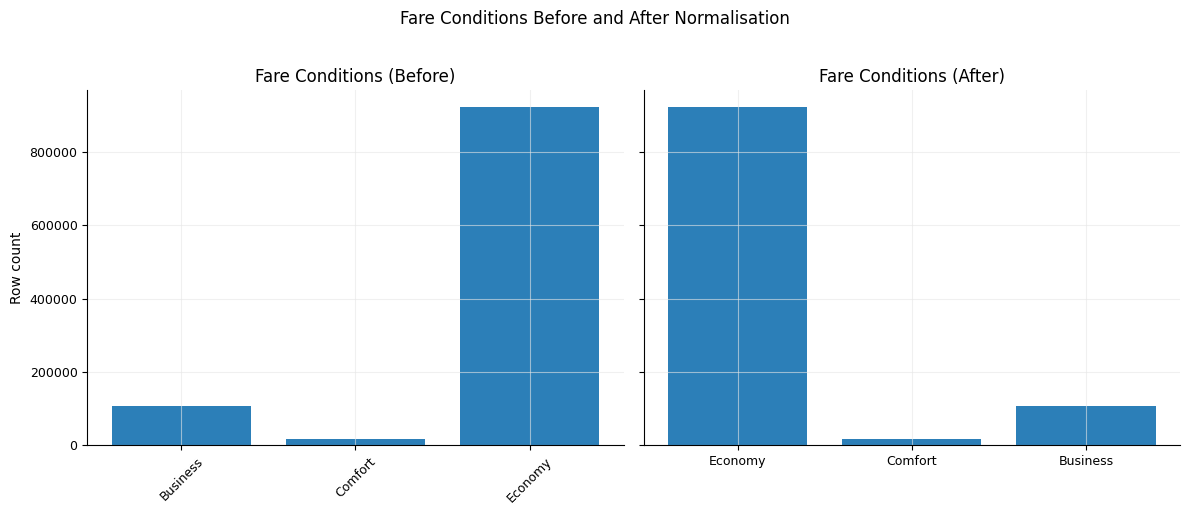

Saved FIGURE -> /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/figures/figure_3_2_1_fare_conditions_before_after.png
Report snippet: After normalisation – Economy 920,793, Comfort 17,291, Business 107,642 (total 1,045,726).


In [24]:
plt.close('all')

fc = pd.read_sql("SELECT fare_conditions FROM ticket_flights;", conn)

# Before / 之前
before = (fc['fare_conditions'].astype(str)
          .value_counts(dropna=False).sort_index())

# After (cleanup) / 之后（清洗后）
def clean_fc(s):
    if pd.isna(s): return pd.NA
    s = str(s).strip().lower()
    if s in ['economy','econ','eco']:   return 'Economy'
    if s in ['comfort','premium economy','prem eco','prem_econ','premeco']: return 'Comfort'
    if s in ['business','biz','bus']:   return 'Business'
    return s.title()

fc['fare_clean'] = fc['fare_conditions'].apply(clean_fc)
after = (fc['fare_clean'].value_counts(dropna=False)
         .reindex(['Economy','Comfort','Business',pd.NA], fill_value=0))

# Plot -> PNG only (no table) / 仅保存 PNG 图（不输出表）
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
axes[0].bar(before.index.astype(str), before.values)
axes[0].set_title("Fare Conditions (Before)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Row count")

axes[1].bar(['Economy','Comfort','Business'], after[['Economy','Comfort','Business']].values)
axes[1].set_title("Fare Conditions (After)")
axes[1].tick_params(axis='x', rotation=0)

fig.suptitle("Fare Conditions Before and After Normalisation", y=1.02)
fig.tight_layout()
png = FIG_DIR/"figure_3_2_1_fare_conditions_before_after.png"
fig.savefig(png, dpi=300, bbox_inches='tight'); plt.show()
print("Saved FIGURE ->", png)

tot = int(len(fc))
eco, comf, biz = [int(after.get(k,0)) for k in ['Economy','Comfort','Business']]
print(f"Report snippet: After normalisation – Economy {eco:,}, Comfort {comf:,}, Business {biz:,} (total {tot:,}).")


In [25]:
import os, json, sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dirs / 目录
TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

def to_utc(s):
    return pd.to_datetime(s, errors='coerce', utc=True)

def get_json_en(sr: pd.Series):
    def _x(s):
        if pd.isna(s) or s == '\\N': return pd.NA
        try:
            return json.loads(s).get('en', pd.NA)
        except Exception:
            return pd.NA
    return sr.apply(_x)

# Base tables / —— 基础表
fl = pd.read_sql("""
    SELECT flight_id, departure_airport, arrival_airport, scheduled_departure, scheduled_arrival,
           status, aircraft_code
    FROM flights
    WHERE UPPER(status)='ARRIVED';
""", conn)

tf = pd.read_sql("SELECT ticket_no, flight_id, fare_conditions, amount FROM ticket_flights;", conn)
t  = pd.read_sql("SELECT ticket_no, book_ref FROM tickets;", conn)
b  = pd.read_sql("SELECT book_ref, book_date FROM bookings;", conn)
ac = pd.read_sql("SELECT aircraft_code, model, range FROM aircrafts_data;", conn)
ap = pd.read_sql("SELECT airport_code, airport_name, timezone, coordinates FROM airports_data;", conn)
seats = pd.read_sql("SELECT aircraft_code, seat_no FROM seats;", conn)

# —— 时间统一为 UTC + 核心时间特征
fl['dep_utc'] = to_utc(fl['scheduled_departure'])
fl['arr_utc'] = to_utc(fl['scheduled_arrival'])
fl['Sched_Flight_Duration_Minutes'] = (fl['arr_utc'] - fl['dep_utc']).dt.total_seconds()/60
# 异常置空（与 3.2.2.D 策略一致）
fl.loc[fl['Sched_Flight_Duration_Minutes'] < 0, 'Sched_Flight_Duration_Minutes'] = pd.NA

b['book_utc'] = to_utc(b['book_date'])

# —— aircraft/model 文本清洗（英文标签）
ac['Aircraft_Model_EN'] = get_json_en(ac['model'])

# —— 座位数（用 seats 明细计数）
seat_cnt = seats.groupby('aircraft_code', as_index=False)['seat_no'].nunique()
seat_cnt = seat_cnt.rename(columns={'seat_no':'Seats_Per_Aircraft'})

# —— 业务规则：Widebody 
# 规则A：座位数 ≥ 240 视为宽体
# 规则B：机型名称包含以下关键字也视为宽体（保险）
WIDEBODY_KEYWORDS = ['777','787','747','767','a330','a340','a350','a380','il-96']
SEAT_THRESHOLD = 240

ac2 = (ac.merge(seat_cnt, on='aircraft_code', how='left')
         .assign(Seats_Per_Aircraft=lambda d: d['Seats_Per_Aircraft'].fillna(0).astype(int)))
def is_widebody(row):
    seats_ok = row['Seats_Per_Aircraft'] >= SEAT_THRESHOLD
    name = str(row['Aircraft_Model_EN']).lower()
    kw_ok = any(k in name for k in WIDEBODY_KEYWORDS)
    return bool(seats_ok or kw_ok)
ac2['Is_Widebody'] = ac2.apply(is_widebody, axis=1)

# —— 拼接为 “segment” 粒度数据
seg = (tf.merge(fl[['flight_id','departure_airport','arrival_airport','dep_utc',
                    'Sched_Flight_Duration_Minutes','aircraft_code']],
                on='flight_id', how='inner')
         .merge(t[['ticket_no','book_ref']], on='ticket_no', how='inner')
         .merge(b[['book_ref','book_utc']], on='book_ref', how='inner')
         .merge(ac2[['aircraft_code','Aircraft_Model_EN','Seats_Per_Aircraft','Is_Widebody']],
                on='aircraft_code', how='left'))

# —— Route & lead time / —— 路线与提前期
seg['Route_Code'] = seg['departure_airport'] + '-' + seg['arrival_airport']
seg['Booking_Lead_Time_Days'] = (seg['dep_utc'] - seg['book_utc']).dt.total_seconds()/86400
seg.loc[seg['Booking_Lead_Time_Days'] < 0, 'Booking_Lead_Time_Days'] = pd.NA  # 与 3.2 策略一致

# —— Seasonality / —— 季节性
seg['Departure_DOW']  = seg['dep_utc'].dt.dayofweek   # 0=Mon
seg['Departure_Hour'] = seg['dep_utc'].dt.hour
seg['Is_Weekend']     = seg['Departure_DOW'].isin([5,6]).astype(int)

# —— Cabin/票舱
def clean_fc(s):
    if pd.isna(s): return pd.NA
    s = str(s).strip().lower()
    if s in ['economy','econ','eco']:   return 'Economy'
    if s in ['comfort','premium economy','prem eco','prem_econ','premeco']: return 'Comfort'
    if s in ['business','biz','bus']:   return 'Business'
    return s.title()
seg['Fare_Class'] = seg['fare_conditions'].apply(clean_fc)
seg['Fare_Class_Ordinal'] = seg['Fare_Class'].map({'Economy':0,'Comfort':1,'Business':2})
seg['Is_Premium_Cabin']   = seg['Fare_Class'].isin(['Comfort','Business']).astype(int)

# Optional: long-haul flag (canvas/rules adjustable) / —— 可选：长航程标记（画布/规则可改）
seg['Is_LongHaul'] = (seg['Sched_Flight_Duration_Minutes'] >= 240).astype(int)

# Keep only columns needed for display (raw + new features) / 仅保留展示所需列（原始 + 新特征）
cols = ['ticket_no','book_ref','flight_id','Route_Code',
        'Sched_Flight_Duration_Minutes','Booking_Lead_Time_Days',
        'Departure_DOW','Departure_Hour','Is_Weekend',
        'Fare_Class','Fare_Class_Ordinal','Is_Premium_Cabin',
        'aircraft_code','Aircraft_Model_EN','Seats_Per_Aircraft','Is_Widebody',
        'amount']
seg = seg[cols].copy()

print("Segment table is ready:", seg.shape)
seg.head()

# Save feature matrix/target for downstream notebooks / 保存特征矩阵与目标供下游 notebook 使用
out_dir = OUT_DIR
out_dir.mkdir(parents=True, exist_ok=True)
seg_clean = seg.copy()
seg_clean["amount"] = pd.to_numeric(seg_clean["amount"], errors="coerce")
seg_clean = seg_clean.dropna(subset=["amount"])
X_features = seg_clean.drop(columns=["amount"])
y_target = seg_clean[["amount"]]
X_features.to_parquet(out_dir/"X_features.parquet", index=False)
y_target.to_parquet(out_dir/"y_target.parquet", index=False)
print("Saved:", out_dir/"X_features.parquet", out_dir/"y_target.parquet")


Segment table is ready: (574830, 17)
Saved: /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/X_features.parquet /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/segment/y_target.parquet


In [26]:
# 4.2.1 — Compare target transformations & export a report-ready table + text / 4.2.1 — 比较目标变换并导出报告用表格与文本
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, KFold

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

X_path = find_path("X_features.parquet")
y_path = find_path("y_target.parquet")

X = pd.read_parquet(X_path)
y = pd.read_parquet(y_path).squeeze()
y = pd.to_numeric(y, errors="coerce")

dt_cols  = [c for c in X.columns if is_datetime64_any_dtype(X[c])]
num_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if (c not in num_cols) and (c not in dt_cols)]

# 保守处理：删除 datetime，布尔转 0/1
if dt_cols:
    X = X.drop(columns=dt_cols)
for c in X.select_dtypes(include="bool").columns:
    X[c] = X[c].astype(int)

# 可选抽样（若内存紧张把 N 调小；想用全量就设置 N = len(X)）
N = min(150_000, len(X))
idx = X.sample(n=N, random_state=42).index
X, y = X.loc[idx].copy(), y.loc[idx].copy()

# OHE 输出稀疏，需要数值侧配合 StandardScaler(with_mean=False)，回归器选 Ridge 以支持稀疏
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",  StandardScaler(with_mean=False))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", ohe)]), cat_cols)
])

base_reg = Ridge(alpha=1.0)

# Three target transformations / 三种目标变换
pipe_X = Pipeline([("pre", pre), ("reg", base_reg)])
pipe_log = TransformedTargetRegressor(regressor=pipe_X,
                                      func=np.log1p, inverse_func=np.expm1)
pipe_yj  = TransformedTargetRegressor(regressor=pipe_X,
                                      transformer=PowerTransformer(method="yeo-johnson"))

models = {
    "Original": pipe_X,
    "Log":      pipe_log,
    "Yeo-Johnson": pipe_yj
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rows = []
for name, est in models.items():
    scores = cross_validate(
        est, X, y,
        scoring={"r2":"r2","rmse":"neg_root_mean_squared_error"},
        cv=cv, n_jobs=-1, return_train_score=False
    )
    r2   = scores["test_r2"];        rmse = -scores["test_rmse"]
    rows.append({"Target Transform": name,
                 "CV folds": cv.n_splits,
                 "Mean R²": r2.mean(), "Std R²": r2.std(),
                 "Mean RMSE": rmse.mean(), "Std RMSE": rmse.std()})

tbl = (pd.DataFrame(rows)
         .sort_values("Mean R²", ascending=False)
         .reset_index(drop=True))

# 保存 CSV
csv_path = TAB_DIR/"table_4_2_1_target_transformations.csv"
tbl.to_csv(csv_path, index=False)
print(f"Saved CSV -> {_rel(csv_path)}\n")
display(tbl.style.format({"Mean R²":"{:.3f}","Std R²":"{:.3f}",
                          "Mean RMSE":"{:.1f}","Std RMSE":"{:.1f}"}))

# —— 生成“可直接粘贴 Word 的结论段”（固定采用对数变换；并报告三组平均指标）
def fmt(x, p=3): return f"{x:.{p}f}"
r0 = tbl.loc[tbl["Target Transform"]=="Original"].iloc[0]
rL = tbl.loc[tbl["Target Transform"]=="Log"].iloc[0]
rY = tbl.loc[tbl["Target Transform"]=="Yeo-Johnson"].iloc[0]

text = (
    "Target transformation comparison (5-fold CV, Ridge baseline). "
    f"Original target achieved mean R²={fmt(r0['Mean R²'])}, RMSE={fmt(r0['Mean RMSE'],1)}. "
    f"Log transform achieved mean R²={fmt(rL['Mean R²'])}, RMSE={fmt(rL['Mean RMSE'],1)}. "
    f"Yeo–Johnson achieved mean R²={fmt(rY['Mean R²'])}, RMSE={fmt(rY['Mean RMSE'],1)}. "
    "Decision: adopt the Log transform for Chapters 5–8 for its accuracy and interpretability; "
    "apply the unbiased log-normal correction when back-transforming predictions."
)

with open(TAB_DIR/"section_4_2_1_text.txt","w",encoding="utf-8") as f:
    f.write(text)

print("\nReport-ready paragraph (also saved to tables/section_4_2_1_text.txt):\n")
print(text)


Saved CSV -> outputs/segment/tables/table_4_2_1_target_transformations.csv



,Target Transform,CV folds,Mean R²,Std R²,Mean RMSE,Std RMSE
0,Log,5,0.999,0.000,530.0,13.2
1,Yeo-Johnson,5,0.885,0.004,7641.7,262.5
2,Original,5,0.806,0.002,9929.4,187.5



Report-ready paragraph (also saved to tables/section_4_2_1_text.txt):

Target transformation comparison (5-fold CV, Ridge baseline). Original target achieved mean R²=0.806, RMSE=9929.4. Log transform achieved mean R²=0.999, RMSE=530.0. Yeo–Johnson achieved mean R²=0.885, RMSE=7641.7. Decision: adopt the Log transform for Chapters 5–8 for its accuracy and interpretability; apply the unbiased log-normal correction when back-transforming predictions.


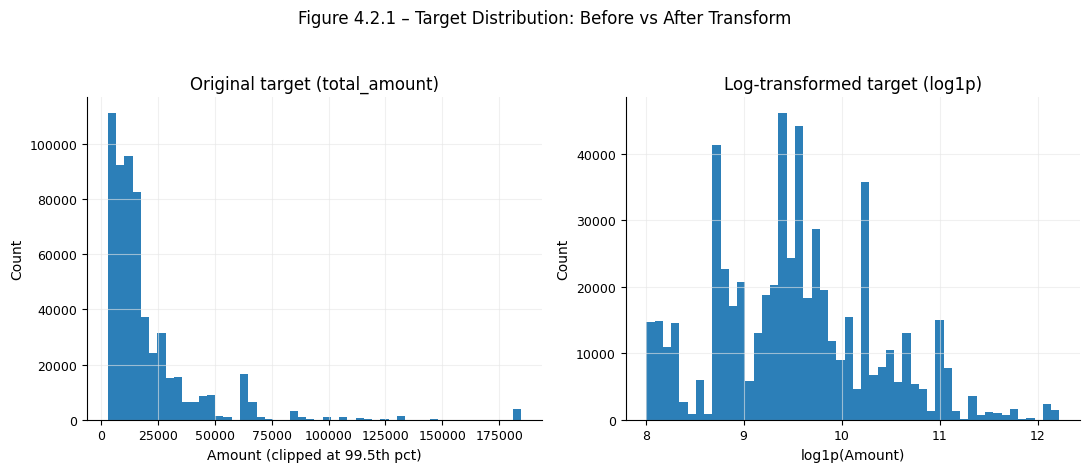

Saved PNG -> outputs/segment/figures/figure_4_2_1_target_distribution.png


In [27]:
# 4.2.1 — Two histograms: original vs log1p(target) / 4.2.1 — 两张直方图：原始 vs log1p(target)
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

FIG_DIR.mkdir(parents=True, exist_ok=True)

y_path = find_path("y_target.parquet")
y = pd.read_parquet(y_path).squeeze()
y = pd.to_numeric(y, errors="coerce").dropna()

y_log = np.log1p(y)

p = np.quantile(y, 0.995)  # 裁剪右尾以便观察主体
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

axes[0].hist(y.clip(upper=p), bins=50)
axes[0].set_title("Original target (total_amount)")
axes[0].set_xlabel("Amount (clipped at 99.5th pct)"); axes[0].set_ylabel("Count")

axes[1].hist(y_log, bins=50)
axes[1].set_title("Log-transformed target (log1p)")
axes[1].set_xlabel("log1p(Amount)"); axes[1].set_ylabel("Count")

fig.suptitle("Figure 4.2.1 – Target Distribution: Before vs After Transform", y=1.04)
plt.tight_layout()

png_path = FIG_DIR/"figure_4_2_1_target_distribution.png"
plt.savefig(png_path, dpi=220, bbox_inches="tight")
plt.show()
print(f"Saved PNG -> {_rel(png_path)}")


In [28]:
# Health check: paths, data objects, parquet existence / 健康检查：路径、数据对象、parquet 是否存在
import os, pandas as pd

print("Working dir:", os.getcwd())
need = ["X_features.parquet", "y_target.parquet", "master_formatted.parquet"]
for f in need:
    print(f"{f:>28} :", "FOUND" if os.path.exists(f) else "missing")

# Check if key objects already in memory / 检查内存里是否已有关键对象
for name in ["master_df", "booking_model_df", "X", "y"]:
    print(f"{name:>18} in memory:", name in globals())

# 若已存在 parquet，查看基本信息
if os.path.exists("X_features.parquet"):
    Xh = pd.read_parquet("X_features.parquet")
    print("X_features shape:", Xh.shape)
if os.path.exists("y_target.parquet"):
    yh = pd.read_parquet("y_target.parquet")
    print("y_target shape:", yh.shape, "; cols:", list(yh.columns))


Working dir: /Users/ethan/Documents/GitHub/airline-revenue-analytics/notebooks/segment
          X_features.parquet : missing
            y_target.parquet : missing
    master_formatted.parquet : missing
         master_df in memory: False
  booking_model_df in memory: False
                 X in memory: True
                 y in memory: True
